# Source Extraction and Dark Region identification with good image query
Trying to take our single queried image and put it through SEP to get a segmentation map. Note that SEP has a dependence on numpy but is incompatible with numpy versions 2.0 and later. This code was written on a machine installed with numpy 1.26.4

Primarily from the [SEP documentation](https://sep.readthedocs.io/en/stable/tutorial.html)

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
import sep

Single image from legacy survey

https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/000/0001m002/legacysurvey-0001m002-image-g.fits.fz
Filename: /Users/vernica/.astropy/cache/download/url/7736deeead2f3b8f68d00b73d4a8bb97/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    142   (3600, 3600)   float32   
None
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 3600 / length of original image axis                  
NAXIS2  =                 3600 / length of original image axis                  
ZDITHER0=                 6049 / dithering offset when quantizing floats        
COMMENT Data product of the DESI Imaging Legacy Surveys                         
COMMENT Full documentati

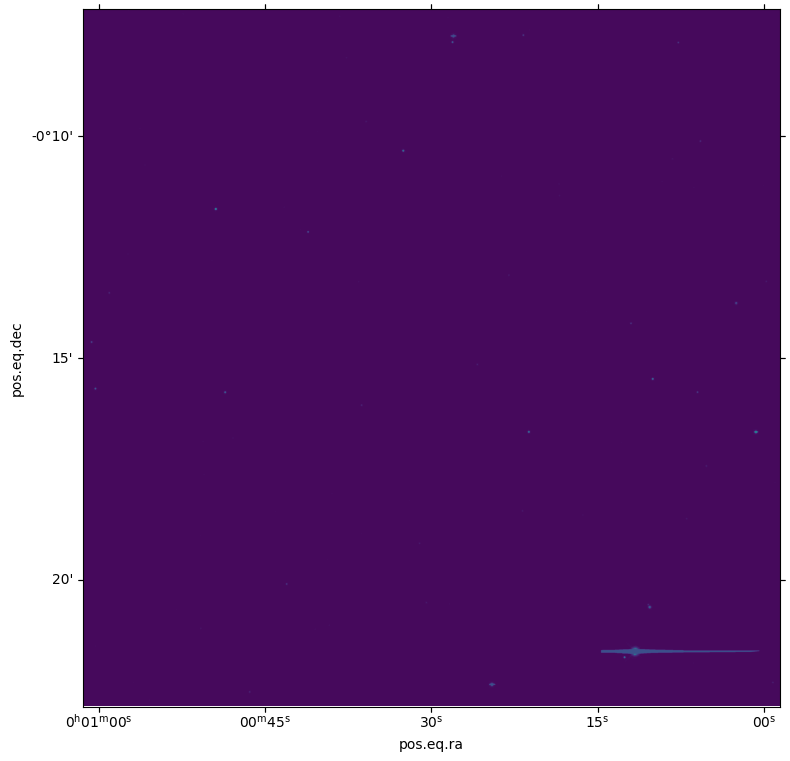

In [75]:
# test_image = fits.open("/mnt/c/Users/creat/Downloads/cutout_190.1086_1.2005.fits")

url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
section = "000"
brick = "0001m002"
filters = "g"
image_string = url + f"{section}/{brick}/legacysurvey-{brick}-image-{filters}.fits.fz"
print(image_string)

test_image = fits.open(image_string)
print(test_image.info())
print(repr(test_image[1].header))

wcs = WCS(test_image[1].header)

zimage = test_image[1].data

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection=wcs)
lon = ax.coords['ra']
lat = ax.coords['dec']
ax.imshow(zimage, norm='linear')


plt.tight_layout()

## Thresholding

We want a magnitude limit of $m_{\text{AB},g}\leq21$, so we need to find the corresponding threshold (related to pixel value). For this we need a zero point. The zero point in this particular image is around 27. We are as yet unsure how to convert magnitude limit to pixel threshold in a meaningful way, so we use an arbitrary value.

In [46]:
## Finding the right zero point to know which threshold to use



## Extraction

We assume that the image is already background subtracted, so we are going straight to extracting sources. Running sep.extract gives two arrays - the first is just the image itself, the second is the segmentation map which is an array of the same shape as the image, where each pixel is assigned an integer value. For our purpose, we only need to extract the integers with a value of 0 (dark regions).

In [288]:
im0 = zimage.byteswap().newbyteorder()
objects = sep.extract(zimage, 1, segmentation_map=True)
seg_map = objects[1]

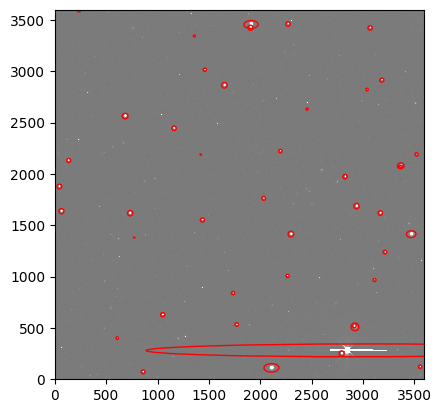

In [289]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(im0), np.std(im0)
im = ax.imshow(im0, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects[0])):
    e = Ellipse(xy=(objects[0]['x'][i], objects[0]['y'][i]),
                width=20*objects[0]['a'][i],
                height=20*objects[0]['b'][i],
                angle=objects[0]['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

Now that we have the data, we extract the segmentation map and rescale it to real sky coords rather than pixels. Every thing in the dr

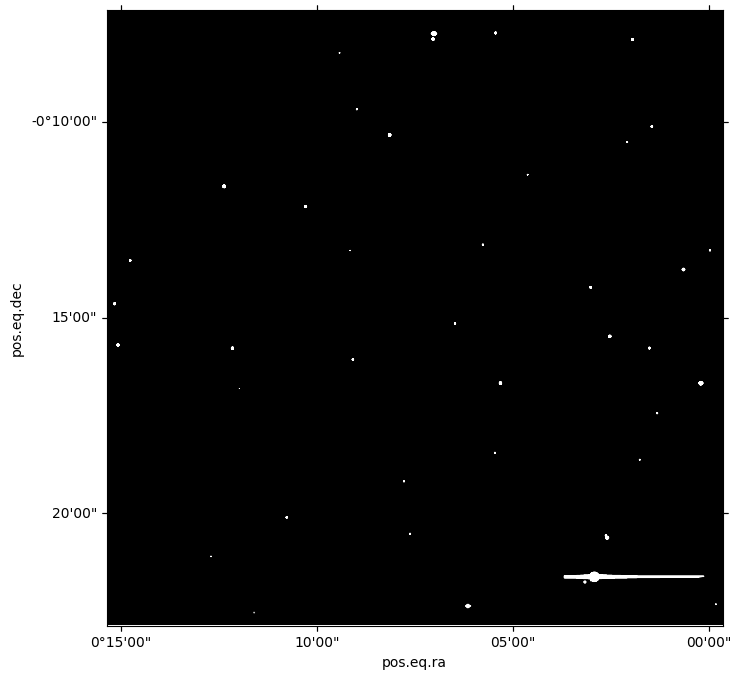

In [290]:
# image coords - pixel scale is uniform for all sources
pixscale = 0.262
ra = test_image[1].header['CRVAL1']
dec = test_image[1].header['CRVAL2']

fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')

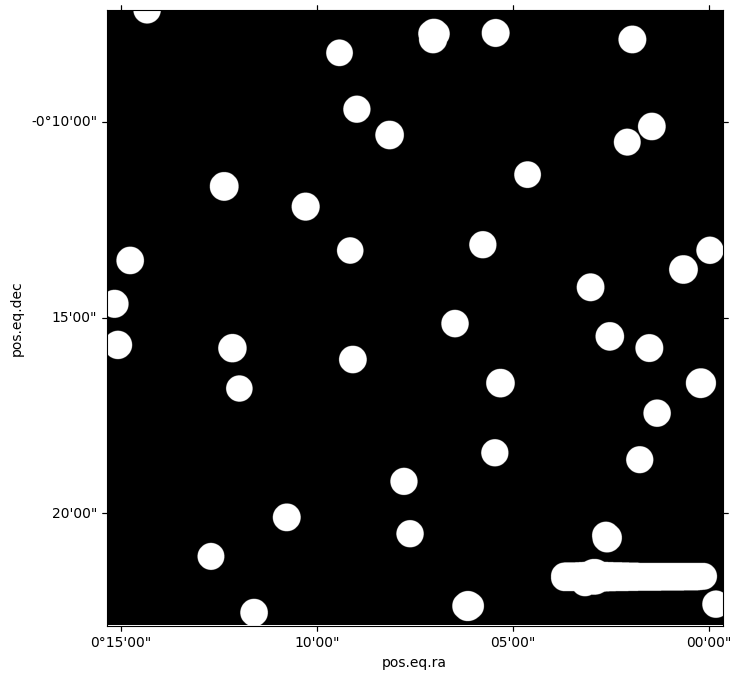

In [291]:
from scipy.ndimage import distance_transform_edt

# Calculate the distance transform of the seg_map
distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

# Expand seg_map for exclusion zones
excl_map = np.copy(seg_map)
excl_map[distance <= 20] = 1

# Plot the updated seg_map
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111, projection=wcs)
plt.imshow(excl_map, origin='lower', cmap='gray', vmin=0, vmax=1)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
plt.show()



In [292]:
fov = 45
gridscale = fov//pixscale

gridlines = np.arange(0,3600,gridscale)
gridlines = gridlines.astype(int)

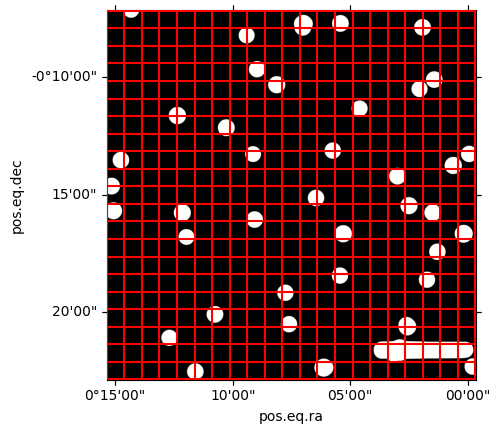

In [293]:
# Applying grid algorithm to the exclusion map
import astropy.units as u
from astropy.visualization import (MinMaxInterval, ImageNormalize)

fig = plt.figure();
ax = fig.add_subplot(111, projection=wcs)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)

norm = ImageNormalize(excl_map, MinMaxInterval())
plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
plt.vlines(gridlines,0,3600,colors='red')
plt.hlines(gridlines,0,3600,colors='red')
plt.margins(0)
plt.show()

In [346]:
dark_x = []
dark_y = []
centers = []

for i in range(len(gridlines[:-1])):
    centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

x_cen, y_cen = np.meshgrid(centers, centers)
x_grid, y_grid = np.meshgrid(gridlines,gridlines)

for x in range(3600):
    for j in range(len(centers)):
        if np.all(excl_map[x][x_grid[j]:x_grid[j+1]] == 0):
            # for y in excl_map.transform():
            #     if np.all(excl_map[y][excl_map[centers[j]][centers[j]]:excl_map[centers[j]][centers[j+1]]]== 0):
                    dark_x.append(x_cen[j])
                    dark_y.append(y_cen[j])

len(dark_y)


TypeError: only integer scalar arrays can be converted to a scalar index

In [340]:
excl_map[2]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

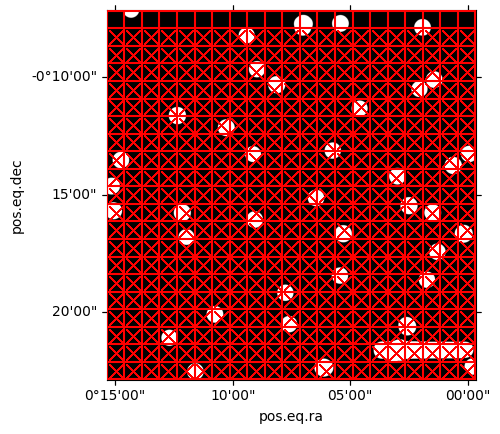

In [343]:
fig = plt.figure();
ax = fig.add_subplot(111, projection=wcs)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)

norm = ImageNormalize(excl_map, MinMaxInterval())
plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
plt.vlines(gridlines,0,3600,colors='red')
plt.hlines(gridlines,0,3600,colors='red')
plt.margins(0)
plt.plot(dark_x, dark_y, 'rx', markersize=10)
plt.show()